# systematics with the Asimov dataset

To assess the impact of various sources of systematic, we will rely on an Asimov dataset.

In [1]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'

from functools import partial
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.optimize import minimize
from tqdm import tqdm_notebook

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=3)
matplotlib.style.use('default')
params = {'legend.fontsize': 20,
          'axes.labelsize': 20,
          'figure.figsize': (8, 8),
          'axes.facecolor': 'white',
          'axes.titlesize':'x-large',
          'xtick.labelsize':18,
          'ytick.labelsize':18,
         }
matplotlib.rcParams.update(params)
%matplotlib inline
%connect_info

/home/naodell/work/wbr/analysis
{
  "shell_port": 32833,
  "iopub_port": 47523,
  "stdin_port": 37035,
  "control_port": 44419,
  "hb_port": 58543,
  "ip": "127.0.0.1",
  "key": "5f259790-844b651ed7eb242add05d9db",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-5e464d4a-f6c1-490c-98d1-d9edde29b761.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
# configure, get the input data, and do any additional processing that is needed
input_dir  = f'local_data/templates/test/'
selections = [
              'ee',   'emu',  'mumu',  
              'mutau', 'etau', 
              'mu4j', 'e4j'
             ]
n_selection = len(selections)
plot_labels = dict(
                   mumu  = [r'$\sf p_{T, \mu}$', r'$\mu\mu$'],
                   ee    = [r'$\sf p_{T, e}$', r'$ee$'],
                   emu   = [r'$\sf p_{T, \ell}$', r'$e\mu$'],
                   mutau = [r'$\sf p_{T, \tau}$', r'$\mu\tau$'],
                   etau  = [r'$\sf p_{T, \tau}$', r'$e\tau$'],
                   mu4j  = [r'$\sf p_{T, \mu}$', r'$\mu$ + jets'],
                   e4j   = [r'$\sf p_{T, e}$', r'$e$ + jets']
                  )

# initial values for W branching fraction (beta_e, beta_mu, beta_tau, beta_h) and tau branching fraction (b_e, b_mu, b_h)
br_tau    = [0.1783, 0.1741, 0.6476]
beta_init = [0.108, 0.108, 0.108, 1 - 3*0.108] 
var_beta  = [0.0009**2, 0.0009**2, 0.0009**2, 0.0031**2]

# initialize fit data
fit_data = fh.FitData(input_dir, selections)
parameters = fit_data._parameters

KeyboardInterrupt: 

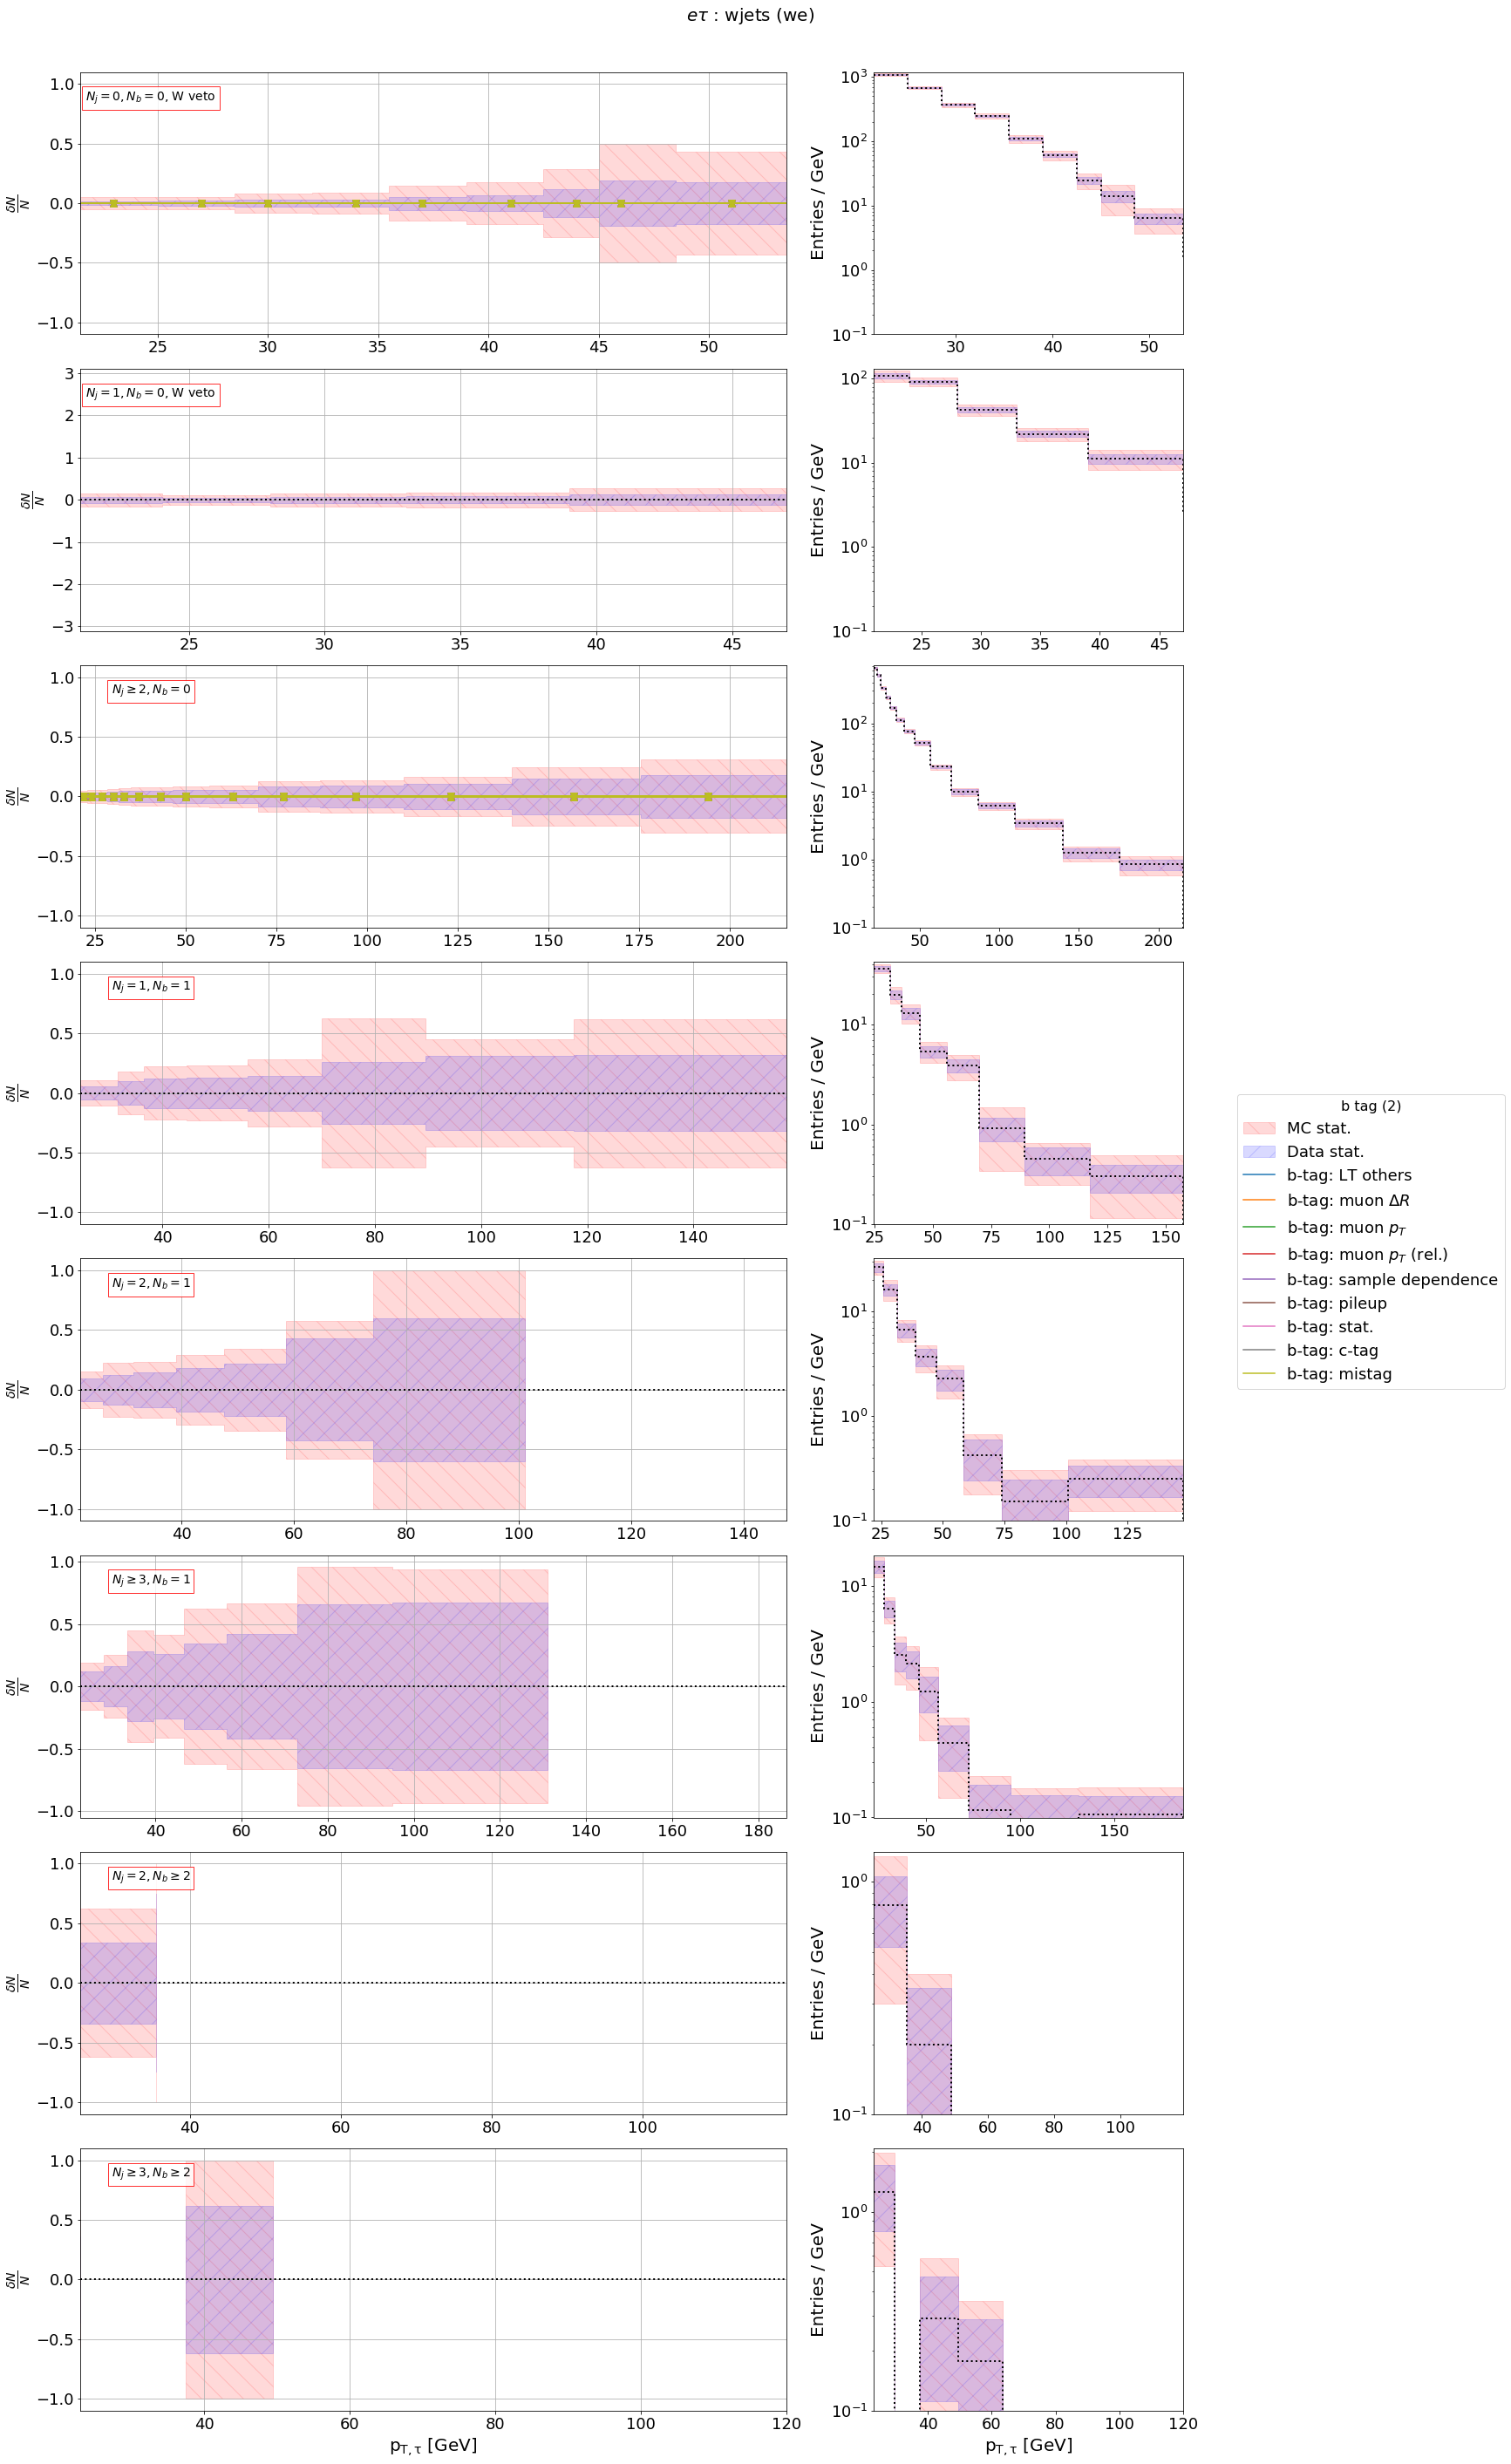

In [3]:
# plot the systematic sources

for selection in selections:
    sdata = fit_data.get_selection_data(selection)
    
    for dataset in pt.selection_dataset_dict[selection]:
        
        if dataset in ['ttbar', 't', 'ww']:
            subdatasets = fit_data._decay_map.query(f'{selection} == 1').decay
        elif dataset in ['wjets']:
            if selection in ['ee', 'etau', 'e4j']:
                subdatasets = ['we', 'wtau_e']
            elif selection in ['mumu', 'mutau', 'mu4j']:
                subdatasets = ['wmu', 'wtau_mu']
            if selection in ['emu']:
                subdatasets = ['we', 'wmu', 'wtau_e', 'wtau_mu']
        elif dataset == 'zjets_alt':
            subdatasets = [None]
        else:
            continue
        
        for subdataset in subdatasets:
            for group in parameters.group.unique():
                if group in ['w_br', 'tau_br']:
                    continue

                params = parameters[parameters.group == group]
                if not np.any(params[selection], 0) or not np.any(params[dataset], 0):
                    continue
                else:
                    params = params.query(f'{selection} == 1 and {dataset} == 1')

                categories = [cat for cat, cat_data in pt.categories.items() if selection in cat_data.selections]
                n_categories = len(categories)

                # one panel for each category 
                fig = plt.figure(figsize=(24, 5*n_categories), facecolor='white')
                gs = gridspec.GridSpec(n_categories, 7, figure=fig)
                legend_data = []
                legend_labels = []
                for ix, category in enumerate(categories):
                    ax = fig.add_subplot(gs[ix,0:4])

                    # get the data
                    templates = sdata[category]['templates']
                    if subdataset == None:
                        template = templates[dataset]
                    else:
                        template = templates[dataset][subdataset]

                    y = template['val']
                    mc_stat_err = np.sqrt(template['var'])
                    data_stat_err = np.sqrt(np.abs(y))
                    
                    if y.sum() == 0:
                        continue

                    bins = sdata[category]['bins'][:-1]
                    dx = (bins[1:] - bins[:-1])
                    dx = np.append(dx, dx[-1]) 
                    x  = bins + dx/2            

                    # statistical error plots
                    ax.plot([x[0], x[-1]], [0, 0], drawstyle='steps-post', c='k', linestyle=':', linewidth=2.)
                    h_mc = ax.fill_between(x, -mc_stat_err/y, mc_stat_err/y, color='r', step='post', hatch='\\', alpha=0.15)
                    h_data = ax.fill_between(x, -data_stat_err/y, data_stat_err/y, color='b', step='post', hatch='/', alpha=0.15)

                    if ix == 0:
                        legend_data.extend([h_mc, h_data])
                        legend_labels.extend(['MC stat.', 'Data stat.'])

                    # loop over relevant parameters
                    for jx, (param, param_data) in enumerate(params.iterrows()):
                        if param_data.type == 'shape':
                            if f'{param}_up' in template.columns: 
                                y_up, y_down = template[f'{param}_up'] - template['val'], template[f'{param}_down'] - template['val']
                            else:
                                continue
                        elif param_data.type == 'norm':
                            y_up, y_down = y*param_data.err_init, -y*param_data.err_init
                        else:
                            continue

                        color = f'C{jx%10}'
                        ax.plot(x, y_up/y, drawstyle='steps-post', c=color, linestyle='-', linewidth=2.)
                        ax.plot(x + dx/2, y_up/y, c=color, marker='^', markersize=8, linestyle='None')
                        ax.plot(x, y_down/y, drawstyle='steps-post', c=color, linestyle='-', linewidth=2.)
                        ax.plot(x + dx/2, y_down/y, c=color, marker='v', markersize=8, linestyle='None')

                        if ix == 0:
                            h_var = matplotlib.lines.Line2D([], [], color=color, linestyle='-')
                            legend_data.append(h_var)
                            legend_labels.append(param_data['label'])

                    if ix == n_categories - 1: 
                        ax.set_xlabel(f'{plot_labels[selection][0]} [GeV]')

                    txt = ax.text(0.1, 0.9, pt.categories[category].label, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=14)
                    txt.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='red'))
                    ax.set_ylabel(r'$\frac{\delta N}{N}$')
                    ax.set_xlim(x[0], x[-2])
                    #ax.set_ylim(-0.05, 0.05)
                    ax.grid()

                    # statistical error plots
                    ax = fig.add_subplot(gs[ix,4:6])
                    ax.plot(x, y/dx, drawstyle='steps-post', c='k', linestyle=':', linewidth=2.)
                    h_mc = ax.fill_between(x, (y-mc_stat_err)/dx, (y+mc_stat_err)/dx, color='r', step='post', hatch='\\', alpha=0.15)
                    h_data = ax.fill_between(x, (y-data_stat_err)/dx, (y+data_stat_err)/dx, color='b', step='post', hatch='/', alpha=0.15)
                    ax.set_xlim(x[0], x[-2])
                    ax.set_ylim(0.1, None)
                    ax.set_ylabel('Entries / GeV')
                    ax.set_yscale('log')
                    if ix == n_categories - 1: 
                        ax.set_xlabel(f'{plot_labels[selection][0]} [GeV]')

                # put legend on seperate axis to avoid scaling weirdness
                if len(legend_labels) > 0:
                    ax = fig.add_subplot(gs[0:,6])
                    legend = ax.legend(handles=legend_data, labels=legend_labels, loc='center left', bbox_to_anchor=(-0.3,0.5), borderaxespad=0, fontsize=18)
                    legend.set_title(f'{params.iloc[0].group_label}', prop={'size':16})
                    ax.axis('off')

                fig.suptitle(f'{plot_labels[selection][1]} : {dataset} ({subdataset})', fontsize=20)
                plt.tight_layout(rect=[0, 0, 0.98, 0.96])
                if subdataset == None:
                    outdir = f'plots/systematics/test/{selection}/{dataset}/'
                else:
                    outdir = f'plots/systematics/test/{selection}/{dataset}_{subdataset}'
                pt.make_directory(outdir, clear=False)
                plt.savefig(f'{outdir}/systematics_{group}.png')
                plt.close()

            #plt.show()